# Are there any difference between Pre-Great-Recession (2003 - 2007) and Post-Great-Recession (2009 - 2013) movies?

First, let's import the packages we will be using and read the data.

In [379]:
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

import gensim #For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [254]:
pre_plot = pandas.read_csv('../Data/pre_plot.csv')
post_plot = pandas.read_csv('../Data/post_plot.csv')
pre_keyword = pandas.read_csv('../Data/pre_keyword.csv')
post_keyword = pandas.read_csv('../Data/post_keyword.csv')
pre_genre = pandas.read_csv('../Data/pre_genre.csv')
post_genre = pandas.read_csv('../Data/post_genre.csv')
pre_gross = pandas.read_csv('../Data/pre_gross.csv')
post_gross = pandas.read_csv('../Data/post_gross.csv')

## Number of movies

The entertainment industry, and in particular Hollywood, is reputed to be “recession-proof”. Box-office receipts rose in six of the last seven recessions, and the Depression, famously, was the heyday of movie attendance in America. However, the Internet has provided people free pieces of entertainment and are thought to be a reason for Hollywood’s newfound susceptibility to an economic downturn. Is movie industry really no longer "recession-proof"? How does it perform in Great Recession period?

Let's first look at the number of movies produced before and after the Great Recession. Note that the movies included here are American movies with plot summaries available on IMDB except Short Films. The reason I exclude movies without plot summaries is since IMDB is a user-collaborative movie encyclopedia website, movies without plot summaries are usually merely noticed and not aired in theaters, thus I choose to not include them here.

In [248]:
len(pre_plot)

6477

In [249]:
len(post_plot)

14654

As we can see, there are more than twice as many movies during Post-Great-Recession period as during Pre-Great-Recession period. 

Then let's look at the domestic box office performance during these two periods.

In [251]:
pre_gross['gross'].describe()

count    1.729000e+03
mean     2.613506e+07
std      5.129810e+07
min      3.000000e+01
25%      9.631400e+04
50%      3.117985e+06
75%      3.255140e+07
max      4.364710e+08
Name: gross, dtype: float64

In [255]:
post_gross['gross'].describe()

count    1.862000e+03
mean     2.758446e+07
std      6.114971e+07
min      0.000000e+00
25%      3.581825e+04
50%      5.404615e+05
75%      2.903829e+07
max      7.605076e+08
Name: gross, dtype: float64

In [261]:
pre_gross[pre_gross['gross']>=100000000]['gross'].describe()

count    1.200000e+02
mean     1.779316e+08
std      7.988288e+07
min      1.004623e+08
25%      1.191140e+08
50%      1.418106e+08
75%      2.155440e+08
max      4.364710e+08
Name: gross, dtype: float64

In [263]:
post_gross[post_gross['gross']>=100000000]['gross'].describe()

count    1.560000e+02
mean     1.905302e+08
std      1.006063e+08
min      1.002406e+08
25%      1.220275e+08
50%      1.551983e+08
75%      2.303120e+08
max      7.605076e+08
Name: gross, dtype: float64

In [265]:
pre_gross[pre_gross['gross']>=200000000]['gross'].describe()

count    3.700000e+01
mean     2.783111e+08
std      6.753091e+07
min      2.000812e+08
25%      2.180800e+08
50%      2.563862e+08
75%      3.192462e+08
max      4.364710e+08
Name: gross, dtype: float64

In [266]:
post_gross[post_gross['gross']>=200000000]['gross'].describe()

count    5.100000e+01
mean     3.018750e+08
std      1.050675e+08
min      2.008219e+08
25%      2.360975e+08
50%      2.773225e+08
75%      3.233122e+08
max      7.605076e+08
Name: gross, dtype: float64

In [269]:
pre_gross[pre_gross['gross'] == max(pre_gross['gross'])]

id    title  year      gross
1139  4311596  Shrek 2  2004  436471036

In [268]:
post_gross[post_gross['gross'] == max(post_gross['gross'])]

id   title  year      gross
144  3394115  Avatar  2009  760507625

Based on the available box office data on IMDB, the mean and median gross of post-Great-Recession movies are slightly higher than those of pre-Great-Recession movies. There are 120 pre-Great-Recession movies having more than 100,000,000 gross and 156 post-Great-Recession movies having more than 100,000,000 gross, and 37 pre-Great-Recession movies having more than 200,000,000 gross and 51 post-Great-Recession movies having more than 100,000,000 gross. The movie with highest gross during pre-Great-Recession period is Shrek 2, with 436,471,036 dolloars, and the movie with highest gross during post-Great-Recession period is Avatar, with 760,507,625 dollars.

Though affected by the inflation, the box office performance still implies that the movie industry has been “recession-proof” during the Great Recession period.

We subsetted movies in both periods with gross larger than 30,000,000 as popular movies for later analysis.

In [271]:
pre25_gross = pre_gross[pre_gross['gross']>=30000000]
post25_gross = post_gross[post_gross['gross']>=30000000]

Next let's look at the distribution of genres in the two periods.

## Distribution of genres

In [288]:
pre_genre_dist = pre_genre.groupby('genre').count()['id'].to_frame().reset_index()
pre_genre_dist.columns = ['Genre', 'Count']

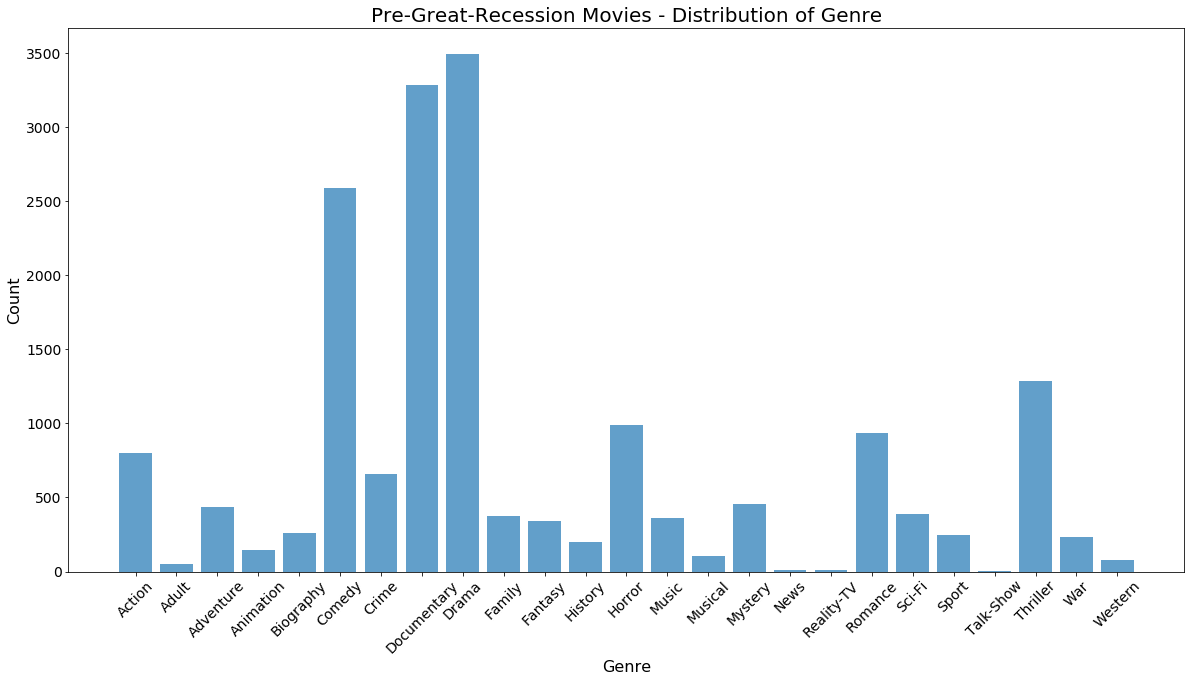

In [290]:
xlabel = pre_genre_dist['Genre']
xlabel_pos = np.arange(len(xlabel))
xdata = pre_genre_dist['Count']
plt.figure(figsize=(20,10))
plt.bar(xlabel_pos, xdata, align='center', alpha=0.7)
plt.xticks(xlabel_pos, xlabel, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Pre-Great-Recession Movies - Distribution of Genre', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

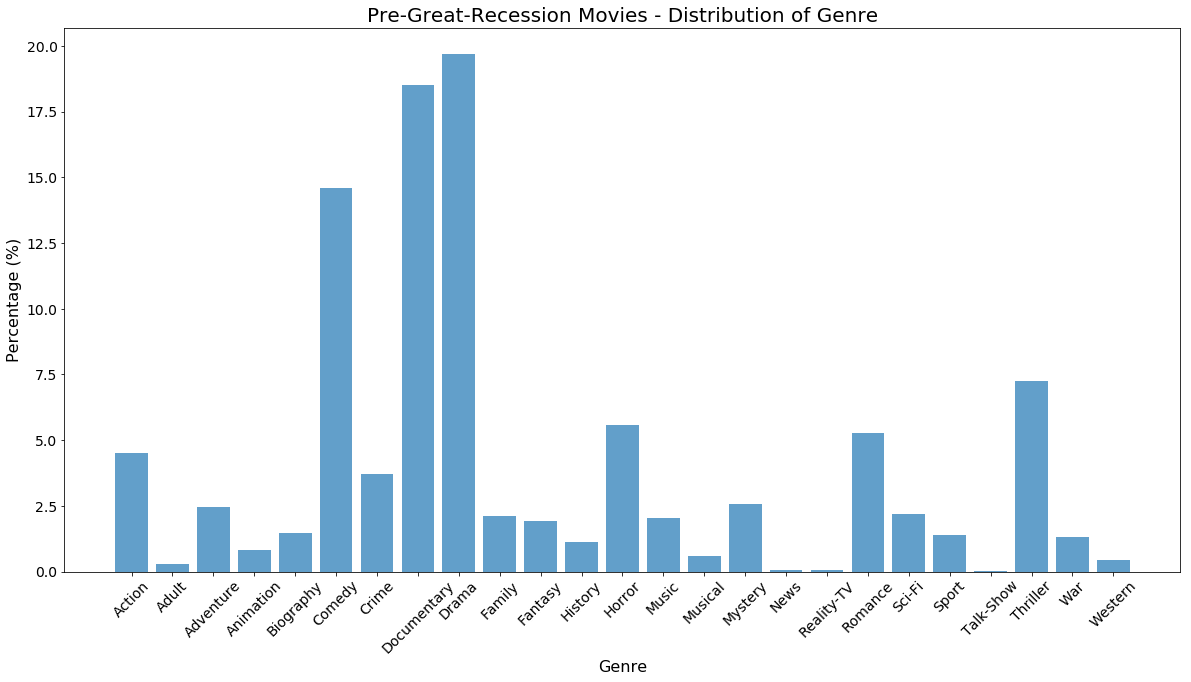

In [291]:
xlabel = pre_genre_dist['Genre']
xlabel_pos = np.arange(len(xlabel))
xdata = pre_genre_dist['Count'] / sum(pre_genre_dist['Count']) * 100
plt.figure(figsize=(20,10))
plt.bar(xlabel_pos, xdata, align='center', alpha=0.7)
plt.xticks(xlabel_pos, xlabel, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Pre-Great-Recession Movies - Distribution of Genre', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=16)
plt.show()

In [245]:
post_genre_dist = post_genre.groupby('genre').count()['id'].to_frame().reset_index()
post_genre_dist.columns = ['Genre', 'Count']

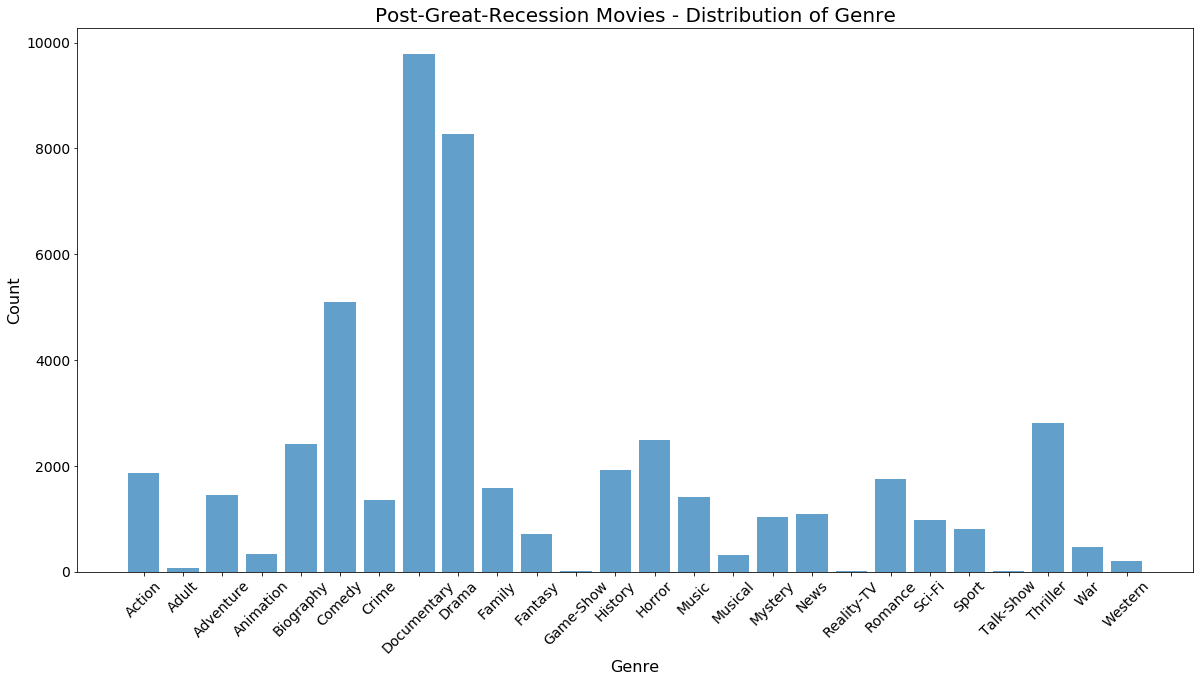

In [292]:
xlabel = post_genre_dist['Genre']
xlabel_pos = np.arange(len(xlabel))
xdata = post_genre_dist['Count']
plt.figure(figsize=(20,10))
plt.bar(xlabel_pos, xdata, align='center', alpha=0.7)
plt.xticks(xlabel_pos, xlabel, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Post-Great-Recession Movies - Distribution of Genre', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

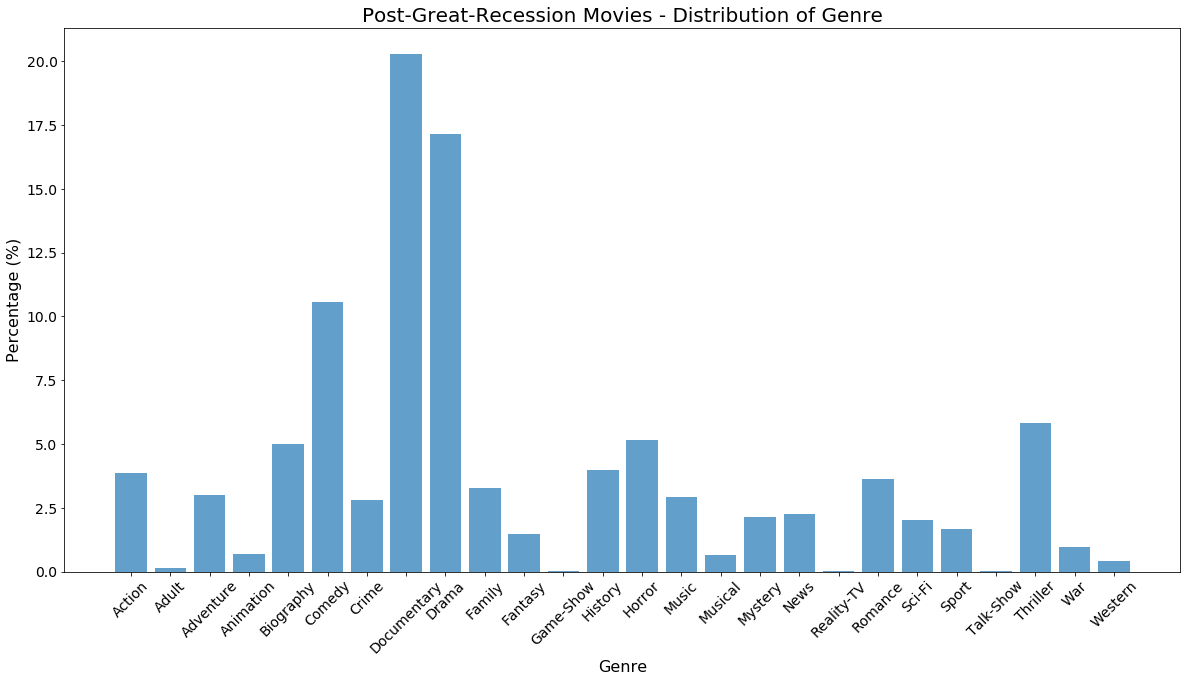

In [293]:
xlabel = post_genre_dist['Genre']
xlabel_pos = np.arange(len(xlabel))
xdata = post_genre_dist['Count'] / sum(post_genre_dist['Count']) * 100
plt.figure(figsize=(20,10))
plt.bar(xlabel_pos, xdata, align='center', alpha=0.7)
plt.xticks(xlabel_pos, xlabel, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Post-Great-Recession Movies - Distribution of Genre', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=16)
plt.show()

As we can see, the overall distributions of genres during pre-Great-Recession period and post-Great-Recession period are similar. However, we can still observe some difference. For example, there are more biography, documentary, family, history, music, news genres, less comedy, crime, drama, fantasy, horror, romance, thriller genres. This is unexpected as the percentage of many genres that are more likely to be realistic increased, while the percentage of many genres that are less realistic and more dramatic decreases. Probably the movie producers no longer cheer people with ideal and lavish stories but present people with the reality.

Let's have a look at the distribution of genres among the popular movies.

In [294]:
pre25_genre = pandas.merge(pre25_gross, pre_genre[['id', 'genre']], on='id', how='left')
pre25_genre_dist = pre25_genre.groupby('genre').count()['id'].to_frame().reset_index()
pre25_genre_dist.columns = ['Genre', 'Count']

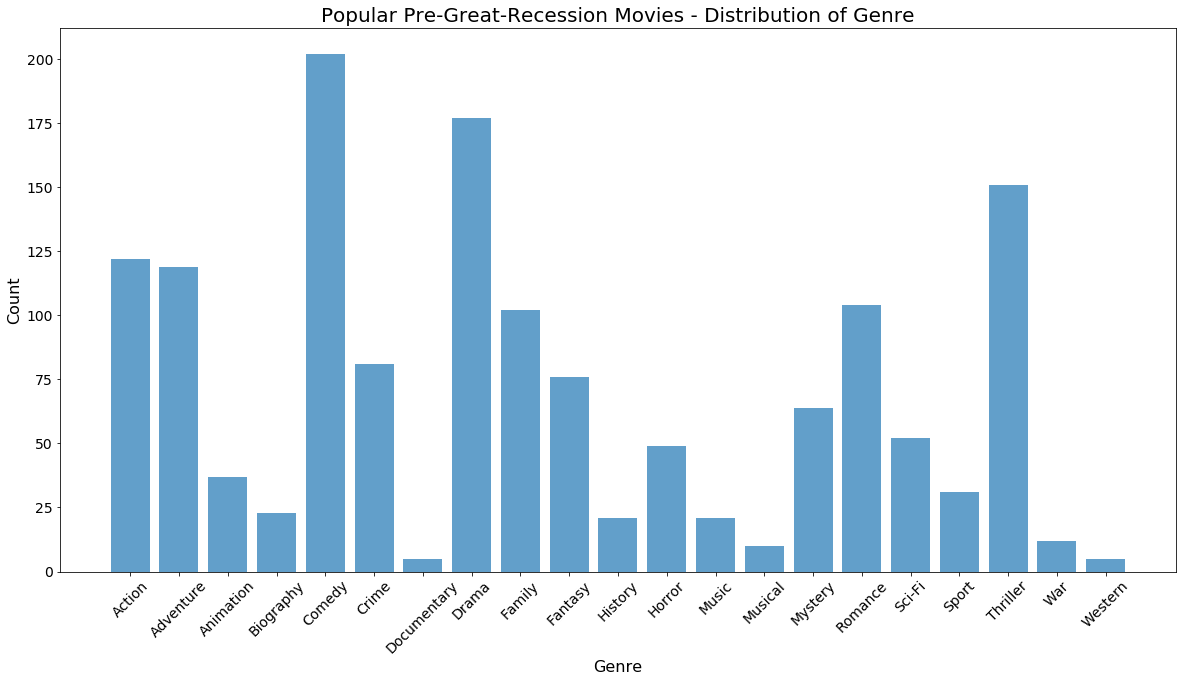

In [295]:
xlabel = pre25_genre_dist['Genre']
xlabel_pos = np.arange(len(xlabel))
xdata = pre25_genre_dist['Count']
plt.figure(figsize=(20,10))
plt.bar(xlabel_pos, xdata, align='center', alpha=0.7)
plt.xticks(xlabel_pos, xlabel, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Popular Pre-Great-Recession Movies - Distribution of Genre', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

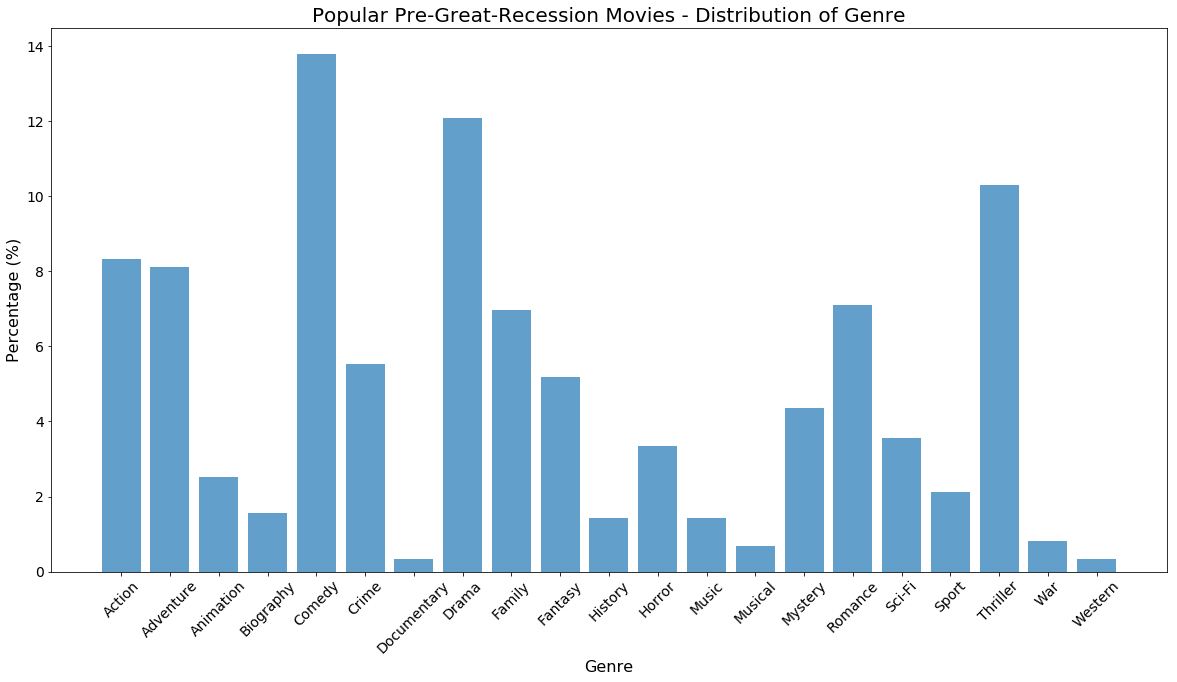

In [296]:
xlabel = pre25_genre_dist['Genre']
xlabel_pos = np.arange(len(xlabel))
xdata = pre25_genre_dist['Count'] / sum(pre25_genre_dist['Count']) * 100
plt.figure(figsize=(20,10))
plt.bar(xlabel_pos, xdata, align='center', alpha=0.7)
plt.xticks(xlabel_pos, xlabel, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Popular Pre-Great-Recession Movies - Distribution of Genre', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=16)
plt.show()

In [297]:
post25_genre = pandas.merge(post25_gross, post_genre[['id', 'genre']], on='id', how='left')
post25_genre_dist = post25_genre.groupby('genre').count()['id'].to_frame().reset_index()
post25_genre_dist.columns = ['Genre', 'Count']

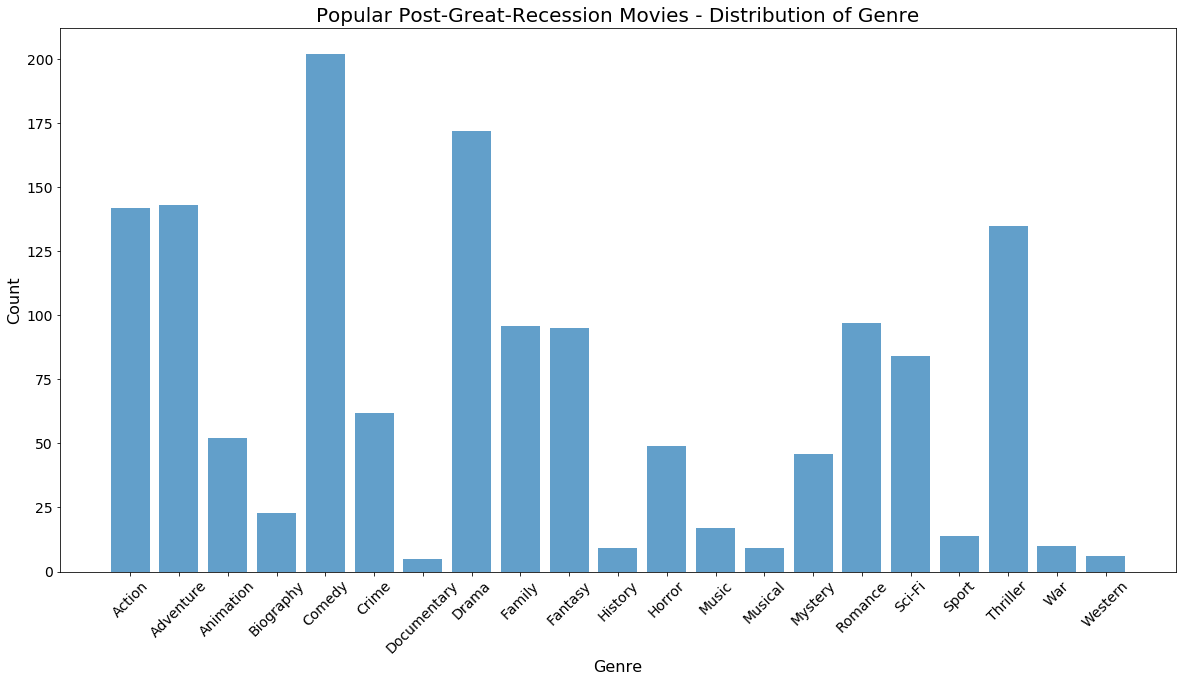

In [298]:
xlabel = post25_genre_dist['Genre']
xlabel_pos = np.arange(len(xlabel))
xdata = post25_genre_dist['Count']
plt.figure(figsize=(20,10))
plt.bar(xlabel_pos, xdata, align='center', alpha=0.7)
plt.xticks(xlabel_pos, xlabel, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Popular Post-Great-Recession Movies - Distribution of Genre', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

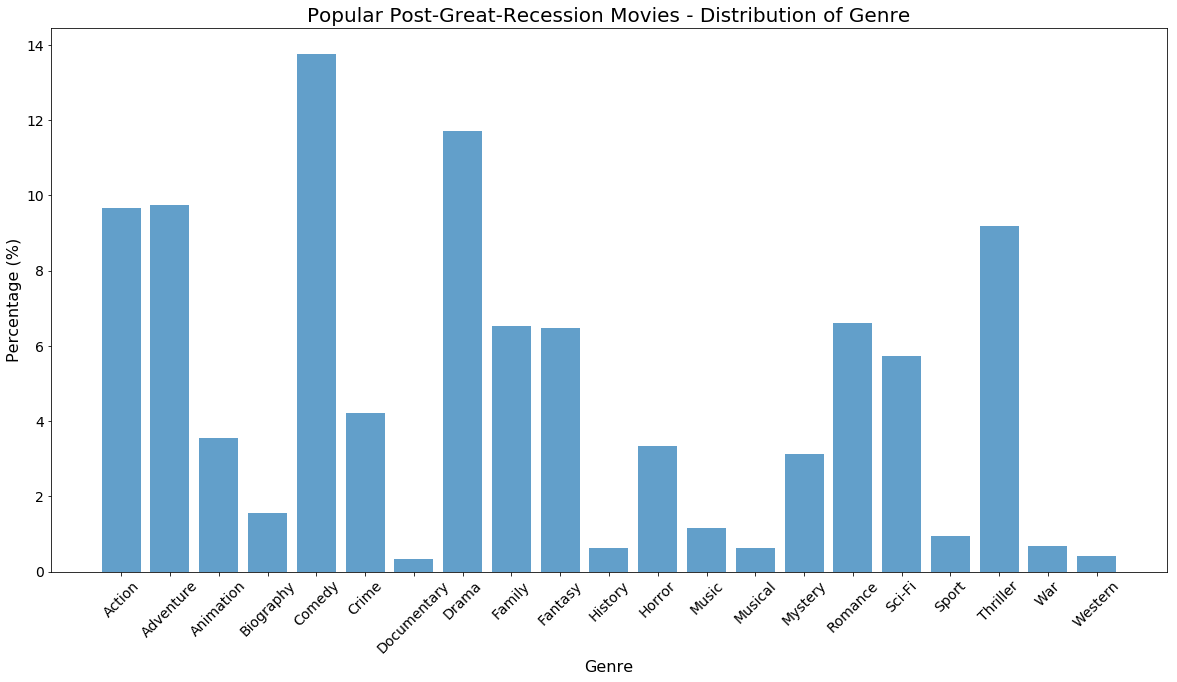

In [299]:
xlabel = post25_genre_dist['Genre']
xlabel_pos = np.arange(len(xlabel))
xdata = post25_genre_dist['Count'] / sum(post25_genre_dist['Count']) * 100
plt.figure(figsize=(20,10))
plt.bar(xlabel_pos, xdata, align='center', alpha=0.7)
plt.xticks(xlabel_pos, xlabel, rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Popular Post-Great-Recession Movies - Distribution of Genre', fontsize=20)
plt.xlabel('Genre', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=16)
plt.show()

Suprisingly, the general distribution of genres among the popular movies in the two periods are also very similar. We can observe that from pre-Great Recession to post-Great Recession, the percentage of genres action, adventure, animation, fantasy, sci-fi increased while the percentage of genres crime, history, mystery, sport, thriller decreased. It seems that although the number of potentially realistic movies increased, people still prefer the movies telling unrealistic and dramatic stories and dislike those movies involving negative emotions such as depression, anxiety in thriller and crime movies.

Next, we will look at the semantics of plot summaries and keywords of movies to see if we can further explore the difference in theme and motif of movies between Pre-Great-Recession and Post-Great-Recession periods.

## Doc2Vec Model

First we would join all the information of each movie.

In [303]:
## Pre-Great-Recession Movies
# plot join keyword
pre_plots = pandas.merge(pre_plot, pre_keyword[['id', 'keyword']], on='id', how='left')
# join genre
pre_genres = pre_genre.groupby('id')['genre'].apply(list).to_frame().reset_index()
pre_plots = pandas.merge(pre_plots, pre_genres, on='id', how='left')
# join popularity
pre25_genre['popularity'] = 'popular pre-recession movies'
pre_plots = pandas.merge(pre_plots, pre25_genre[['id', 'popularity']], on='id', how='left')
# join period
pre_plots['period'] = 'pre-recession'

In [305]:
## Post-Great-Recession Movies
# plot join keyword
post_plots = pandas.merge(post_plot, post_keyword[['id', 'keyword']], on='id', how='left')
# join genre
post_genres = post_genre.groupby('id')['genre'].apply(list).to_frame().reset_index()
post_plots = pandas.merge(post_plots, post_genres, on='id', how='left')
# join popularity
post25_genre['popularity'] = 'popular post-recession movies'
post_plots = pandas.merge(post_plots, post25_genre[['id', 'popularity']], on='id', how='left')
# join period
post_plots['period'] = 'post-recession'

In [306]:
plots = pandas.concat([pre_plots, post_plots], ignore_index=True)
plots[:5]

id                                              title  year  \
0  3279981  $100 & a T-Shirt: A Documentary About Zines in...  2004   
1  3280756  'Some Kind of Funny Porto Rican?': A Cape Verd...  2006   
2  3280876           'Tis Autumn: The Search for Jackie Paris  2006   
3  3281268                     (Yielding to) A Willing Breath  2006   
4  3281368                                     ... Just a Job  2007   

                                                plot  \
0  A cultural analysis of what causes zine makers...   
1  SKFPR is the untold tragedy and scandal of wha...   
2  "'Tis Autumn: The Search For Jackie Paris" is ...   
3  "(Yielding to) A Willing Breath" follows the m...   
4  Born into the legacy of blue collar workers, F...   

                                          keyword          genre popularity  \
0  northwest,number-in-title,portland-oregon,zine  [Documentary]        NaN   
1                                             NaN  [Documentary]        NaN   
2                         character-name-in-title  [Documentary]        NaN   
3                                             NaN        [Drama]        NaN   
4                                             NaN        [Crime]        NaN   

          period  
0  pre-recession  
1  pre-recession  
2  pre-recession  
3  pre-recession  
4  pre-recession

Then let's tokenize and normalize the plot summaries and keywords.

In [126]:
stopwords = list(set(lucem_illud.stop_words_basic) - set(['he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself']))

In [309]:
plots['tokenized_words'] = plots['plot'].apply(lambda x: nltk.word_tokenize(x))
plots['normalized_words'] = plots['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = stopwords, stemmer = None))

In [310]:
plots['keyword'] = plots['keyword'].astype('str')
plots['tokenized_keywords'] = plots['keyword'].apply(lambda x: nltk.word_tokenize(x))
plots['normalized_keywords'] = plots['tokenized_keywords'].apply(lambda x: list(set(x) - set([',', 'nan'])))

In [311]:
plots[:5]

id                                              title  year  \
0  3279981  $100 & a T-Shirt: A Documentary About Zines in...  2004   
1  3280756  'Some Kind of Funny Porto Rican?': A Cape Verd...  2006   
2  3280876           'Tis Autumn: The Search for Jackie Paris  2006   
3  3281268                     (Yielding to) A Willing Breath  2006   
4  3281368                                     ... Just a Job  2007   

                                                plot  \
0  A cultural analysis of what causes zine makers...   
1  SKFPR is the untold tragedy and scandal of wha...   
2  "'Tis Autumn: The Search For Jackie Paris" is ...   
3  "(Yielding to) A Willing Breath" follows the m...   
4  Born into the legacy of blue collar workers, F...   

                                          keyword          genre popularity  \
0  northwest,number-in-title,portland-oregon,zine  [Documentary]        NaN   
1                                             nan  [Documentary]        NaN   
2                         character-name-in-title  [Documentary]        NaN   
3                                             nan        [Drama]        NaN   
4                                             nan        [Crime]        NaN   

          period                                    tokenized_words  \
0  pre-recession  [A, cultural, analysis, of, what, causes, zine...   
1  pre-recession  [SKFPR, is, the, untold, tragedy, and, scandal...   
2  pre-recession  [``, 'T, is, Autumn, :, The, Search, For, Jack...   
3  pre-recession  [``, (, Yielding, to, ), A, Willing, Breath, '...   
4  pre-recession  [Born, into, the, legacy, of, blue, collar, wo...   

                                    normalized_words  \
0  [cultural, analysis, causes, zine, makers, tic...   
1  [skfpr, untold, tragedy, scandal, happened, vi...   
2  [autumn, search, jackie, paris, feature, docum...   
3  [yielding, willing, breath, follows, methodica...   
4  [born, legacy, blue, collar, workers, fred, ne...   

                                  tokenized_keywords  \
0  [northwest, ,, number-in-title, ,, portland-or...   
1                                              [nan]   
2                          [character-name-in-title]   
3                                              [nan]   
4                                              [nan]   

                                 normalized_keywords  
0  [zine, number-in-title, portland-oregon, north...  
1                                                 []  
2                          [character-name-in-title]  
3                                                 []  
4                                                 []

Based on our hypotheses, we find some words as identifications of certain feature of movies. 

Hypothesis 1: One dominant model of movies during the Great Recession is dream world model featured escapism. Characters usually exist in upper-class environments far from any reference.

In [312]:
dream_world_movie = ['surrealism', 'idealism', 'upper-class', 'upperclass', 'upper-class-family', 'upperclassman', 'blue-blood', 'elite', 'maid', 'valet', 'horse', 'utopian', 'lord', 'duke', 'countess', 'lady', 'living-lavish', 'rich','patrician', 'genteel', 'noble', 'aristocrat', 'economic-boom']

Hypothesis 2: Culture industry also feature realism, stoicism and triumph over adversity.

In [313]:
realism_movie = ['realism', 'reality', 'financial crisis', 'recession', 'economic-recession', 'great-recession', 'economic-crisis', 'economic-bust', 'economic-collapse', 'economic-problem', 'economic-hardship', 'economic-recovery', 'global-economic-crisis-of-2008', 'depression', 'great-depression', 'crisis', 'hardship', 'austerity', 'poverty']

Hypothesis 4: Stronger sexual impulse: using sexually explicit content to attract public attention.

In [314]:
sexually_explicit_movie = ['sex', 'sex-scene', 'sex-on-couch', 'sex-in-bed', 'oral-sex', 'sex-standing-up', 'female-nudity', 'male-nudity', 'female-frontal-nudity', 'female-rear-nudity', 'bdsm', 'loss-of-virginity', 'sexual-fantasy', 'sexuality', 'passionate-kiss', 'undressing-someone', 'bare-chested-male', 'man-undressing-a-woman', 'two-in-a-bath', 'sexual-submissiveness', 'sex-toy', 'unsimulated-sex', 'hand-job', 'blow-job', 'sperm', 'penis', 'explicit-sex', 'breast', 'nipple']

Hypothesis 5: Society is looking for individual leadership that would bring them out of the predicament and collective cooperation was devalued. 

In [315]:
individual_leadership_movie = ['leader', 'leadership', 'hero', 'heroine', 'captain', 'individualism', 'anti-socialist', 'anti-communist', 'anti-communism', 'independence', 'team-captain']
cooperation_movie = ['communal-values', 'self-sacrifice', 'socialism', 'sacrifice', 'collectivism', 'collective', 'communism', 'communist', 'community', 'socialist', 'cooperation', 'cooperative', 'team']

Hypothesis 6: Connecting the people with the system. Evoking public emotion toward the country and the government. Emphasizing and promoting positive image of executive, legislative, and judicial system.

In [316]:
patriotism_movie = ['nation', 'country', 'american-dream', 'native-american', 'nationalism', 'patriotism', 'patriotic', 'president', 'u.s.-president', 'white-house', 'government', 'u.s.-government', 'judicial', 'judicial-system', 'law', 'constitution', 'u.s.-constitution']

Hypothesis 7: Hollywood portrays a positive image of the independent working woman on screen.

In [317]:
working_woman_movie = ['female-doctor', 'female-lead', 'female-boss', 'female-hero', 'strong-female', 'female-judge', 'female-leader', 'policewoman', 'working-woman', 'career-woman', 'female-lawyer']

Let's assign a tag, including title, year, genre, period, popularity, feature inferred from keywords, to each plot summary and keyword list. 

In [323]:
taggedPlots = []
taggedKeywords = []
for index, row in plots.iterrows():
    docTags = set()
    for word in dream_world_movie:
        if word in row['normalized_keywords']:
            docTags.add('dream world movie')
    for word in realism_movie:
        if word in row['normalized_keywords']:
            docTags.add('realism movie')
    for word in sexually_explicit_movie:
        if word in row['normalized_keywords']:
            docTags.add('sexually explicit movie')
    for word in individual_leadership_movie:
        if word in row['normalized_keywords']:
            docTags.add('individual leadership movie')
    for word in cooperation_movie:
        if word in row['normalized_keywords']:
            docTags.add('cooperation movie')
    for word in patriotism_movie:
        if word in row['normalized_keywords']:
            docTags.add('patriotism movie')
    for word in working_woman_movie:
        if word in row['normalized_keywords']:
            docTags.add('working woman movie')
    docTags = list(docTags)
    docTags.append(row['title'])
    docTags.append(row['year'])
    docTags.append(row['period'])
    if pandas.notna(row['popularity']):
        docTags.append(row['popularity'])
    try:
        docTags += row['genre']
    except:
        pass
    taggedPlots.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docTags))
    taggedKeywords.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_keywords'], tags = docTags))
plots['TaggedPlots'] = taggedPlots
plots['TaggedKeywords'] = taggedKeywords

In [327]:
plots.iloc[30]['TaggedPlots']

LabeledSentence(words=['movie', 'going', 'focuses', 'young', 'teenage', 'girl', 'name', 'jenna', 'rink', 'suffers', 'humiliating', 'thirteenth', 'birthday', 'makes', 'wish', 'skip', 'ahead', 'she', 'thirty', 'years', 'old', 'magic', 'wishing', 'dust', 'her', 'wish', 'comes', 'true', 'movie', 'transports', 'us', 'jenna', 'exception', 'she', 'still', 'thirteen', 'inside', 'remember', 'anything', 'since', 'her', 'thirteenth', 'birthday', 'she', 'soon', 'realizes', 'her', 'self', 'everything', 'she', 'wanted', 'she', 'younger', 'cool', 'apartment', 'fabulous', 'wardrobe', 'dream', 'job', 'jenna', 'soon', 'realizes', 'even', 'though', 'she', 'everything', 'she', 'could', 'ever', 'want', 'she', 'younger', 'still', 'something', 'missing', 'without', 'her', 'best', 'friend', 'she', 'gets', 'her', 'assistant', 'track', 'matt', 'her', 'dismay', 'she', 'learns', 'her', 'matt', 'estranged', 'since', 'high', 'school', 'matt', 'engaged', 'jenna', 'shows', 'matt', 'wedding', 'he', 'gives', 'jenna', '

Let's build the Doc2Vec models.

In [328]:
plotD2V = gensim.models.doc2vec.Doc2Vec(plots['TaggedPlots'], size = 100) #Limiting to 100 dimensions
plotD2V.save('plotD2V.mm')

In [329]:
keywordD2V = gensim.models.doc2vec.Doc2Vec(plots['TaggedKeywords'], size = 100) #Limiting to 100 dimensions
keywordD2V.save('keywordD2V.mm')

In [440]:
# A function to plot the heatmap of documents against documents/words
def plot_heatmap(target1, target2, modelD2V):
    heatmapMatrix = []
    for tagOuter in target1:
        column = []
        tagVec = modelD2V.docvecs[tagOuter].reshape(1, -1)
        for tagInner in target2:
            column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, modelD2V.docvecs[tagInner].reshape(1, -1))[0][0])
        heatmapMatrix.append(column)
    heatmapMatrix = np.array(heatmapMatrix)

    fig, ax = plt.subplots()
    #hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
    hmap = ax.pcolor(heatmapMatrix)
    cbar = plt.colorbar(hmap)

    cbar.set_label('cosine similarity', rotation=270)
    a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
    a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

    #a = ax.set_xticklabels(target2, minor=False, rotation=270)
    a = ax.set_xticklabels(target2, minor=False)
    a = ax.set_yticklabels(target1, minor=False)

### Overall semantics difference

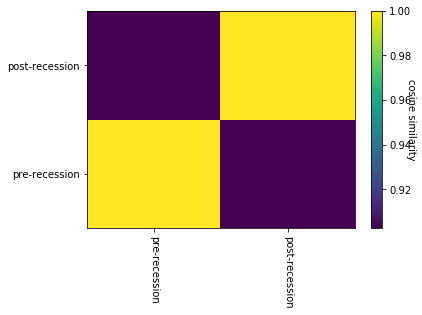

In [411]:
two_periods = ['pre-recession', 'post-recession']
plot_heatmap(two_periods, two_periods, plotD2V)

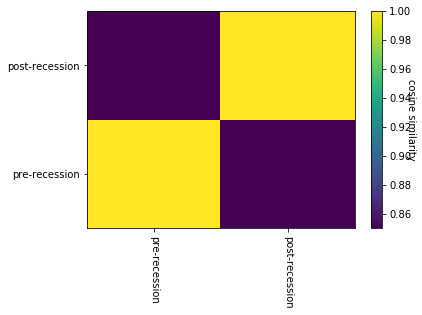

In [412]:
plot_heatmap(two_periods, two_periods, keywordD2V)

It seems that the semantics of pre-Great-Recession movies and post-Great-Recession movies are not that different. Let's include the popular movies.

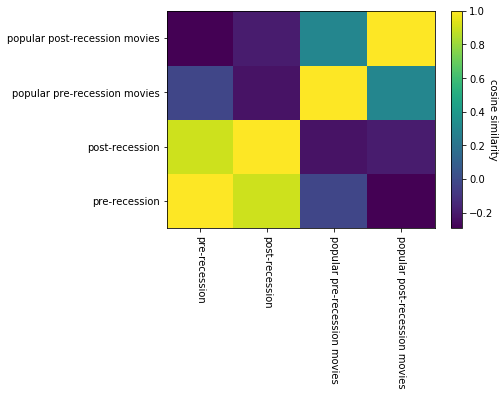

In [426]:
popular_two_periods = ['pre-recession', 'post-recession', 'popular pre-recession movies', 'popular post-recession movies']
plot_heatmap(popular_two_periods, popular_two_periods, plotD2V)

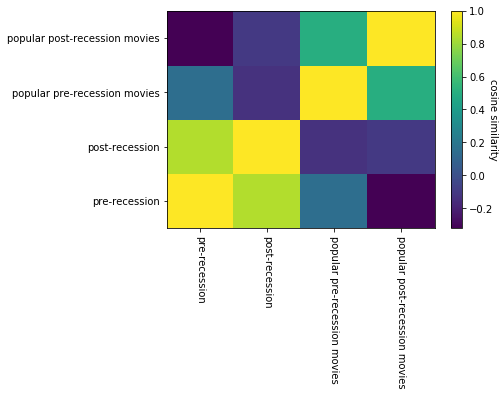

In [414]:
plot_heatmap(popular_two_periods, popular_two_periods, keywordD2V)

We can observe that popular pre-Great-Recession movies are less similar to popular post-Great-Recession movies compared to that between pre-Great-Recession movies and post-Great-Recession movies. Popular pre-Great-Recession movies are less similar to all pre-Great-Recession movies, and popular post-Great-Recession movies are even less similar to all post-Great-Recession movies, which indicates that the popular movies in the two periods are quite different and popular post-Great-Recession movies are a specific part of all movies released during the post-Great-Recession period.

Then let's look at the semantics similarity by year.

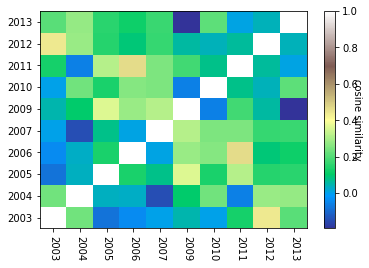

In [340]:
films_year = sorted(list(plots.year.unique()))
plot_heatmap(films_year, films_year, plotD2V)

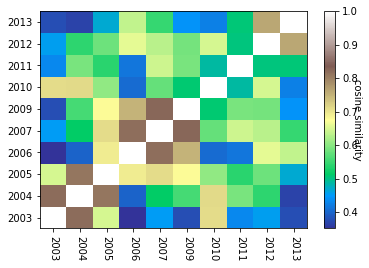

In [343]:
plot_heatmap(films_year, films_year, keywordD2V)

### Semantics components

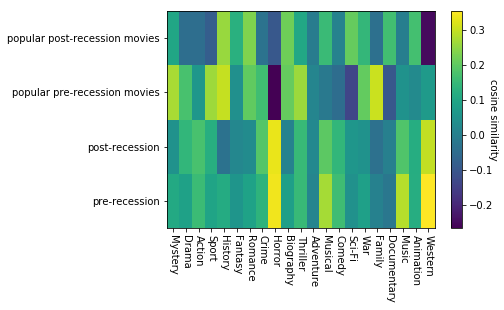

In [436]:
genres = list(set(pre25_genre.genre.unique()) | set(post25_genre.genre.unique()))
plot_heatmap(popular_two_periods, genres, plotD2V)

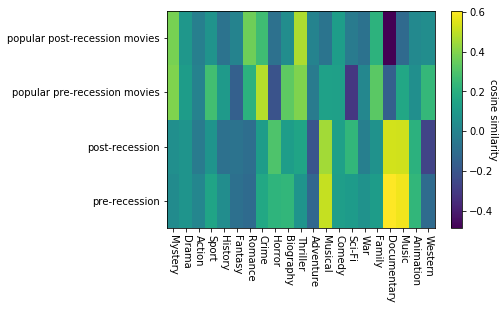

In [437]:
plot_heatmap(popular_two_periods, genres, keywordD2V)

Comparing pre-Great-Recession movies and post-Great-Recession movies, the similarity between all movies and specific genres are quite similar, and post-Great-Recession movies are slightly less similar to history, and biography genres, but more similar to sci-fi genres, which might indicate that the post-Great-Recession movies are actually more unrealistic than pre-Great-Recession movies.

Based on both plot summaries and keywords, popular post-Great-Recession movies are most similar to mystery, romance, thriller, family genres, which indicates that people prefer unrealistic movies during this period. Compared with popular pre-Great-Recession movies, we can see that sport are no longer popular, sci-fi are much more popular.

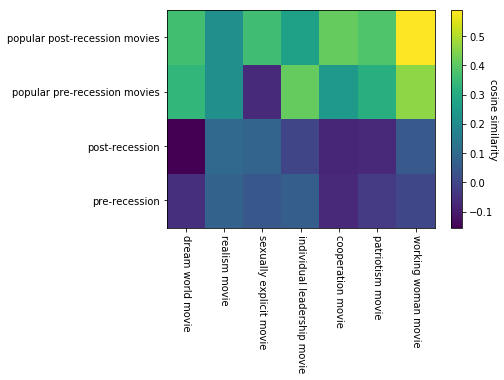

In [415]:
features = ['dream world movie', 'realism movie', 'sexually explicit movie', 'individual leadership movie', 'cooperation movie', 'patriotism movie', 'working woman movie']
plot_heatmap(popular_two_periods, features, plotD2V)

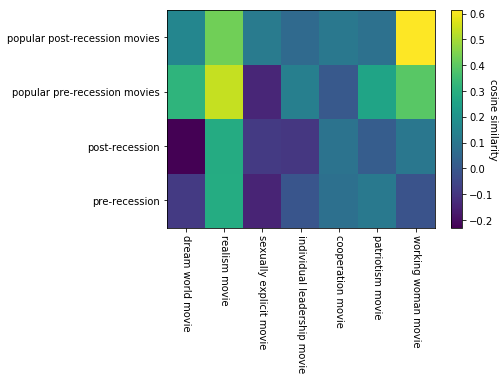

In [416]:
plot_heatmap(popular_two_periods, features, keywordD2V)

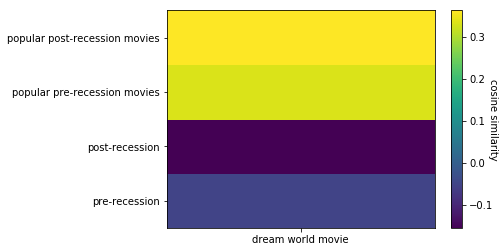

In [430]:
plot_heatmap(popular_two_periods, ['dream world movie'], plotD2V)

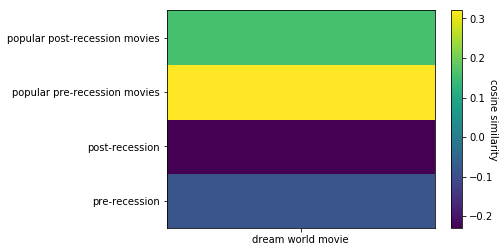

In [431]:
plot_heatmap(popular_two_periods, ['dream world movie'], keywordD2V)

Both plot summaries and keywords show that post-Great-Recession movies are less about "dream world" than pre-Great-Recession movies, however, people really like the "dream world" movies, which implies a gap between movie production and consumer preference. Unlike during the Great Depression period, movie producers are no longer depict "dream world" to provide the escapsism for people, while ordinary people still appreciate those movies about upper class and life far away from them.

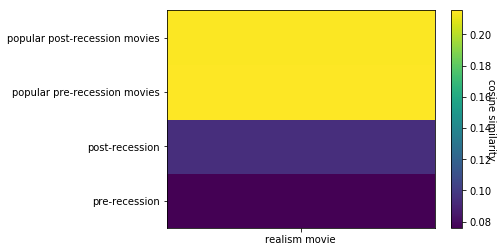

In [432]:
plot_heatmap(popular_two_periods, ['realism movie'], plotD2V)

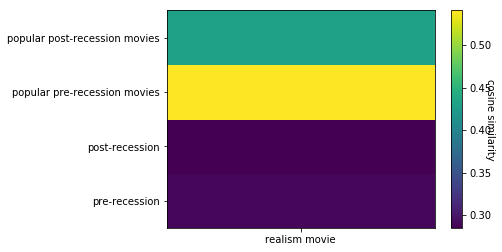

In [434]:
plot_heatmap(popular_two_periods, ['realism movie'], keywordD2V)

Both plot summaries and keywords show that there are more realistic movies depicting economic crisis than "dream world" movies, however, among all the features listed, these are the least liked movies.

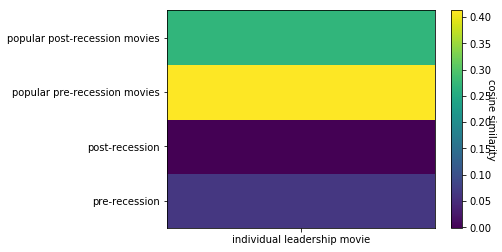

In [441]:
plot_heatmap(popular_two_periods, ['individual leadership movie'], plotD2V)

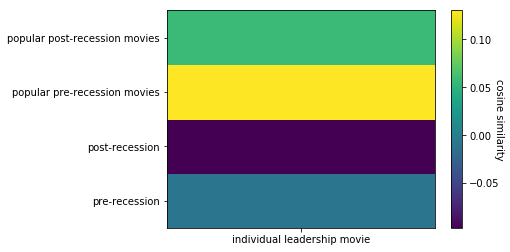

In [442]:
plot_heatmap(popular_two_periods, ['individual leadership movie'], keywordD2V)

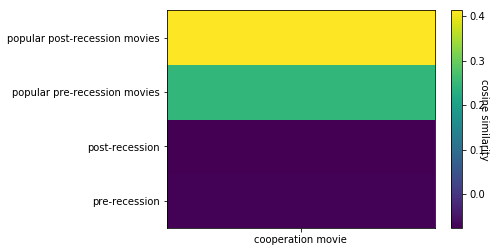

In [443]:
plot_heatmap(popular_two_periods, ['cooperation movie'], plotD2V)

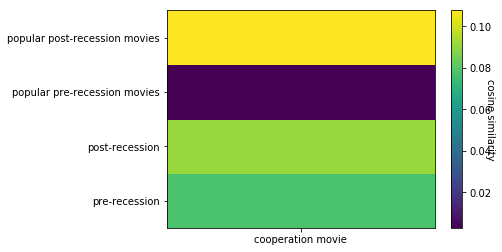

In [444]:
plot_heatmap(popular_two_periods, ['cooperation movie'], keywordD2V)

Plot summaries show that people love individual leadership movies, but they are less excited about them during the post-Great-Recession period. Instead, they are more attracted to cooperation movies.

Plot summaries show that there are less movies about patriotism in post-Great-Recession period than in pre-Great-Recession period, but people like patriotism movies during post-Great-Recession period more than pre-Great-Recession period.

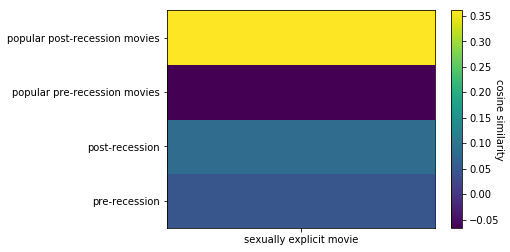

In [445]:
plot_heatmap(popular_two_periods, ['sexually explicit movie'], plotD2V)

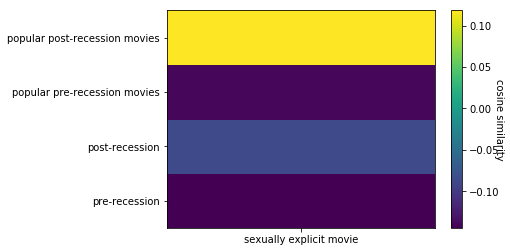

In [446]:
plot_heatmap(popular_two_periods, ['sexually explicit movie'], keywordD2V)

There are not much sexually explicit movies both during pre-Great-Recession period and post-Great-Recession period, but we can see that people extremely love them during the post-Great-Recession period.

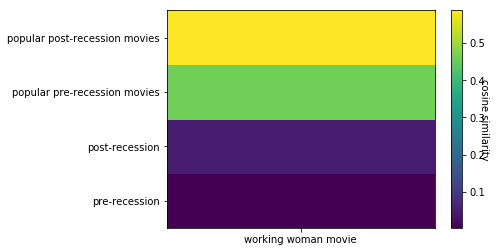

In [447]:
plot_heatmap(popular_two_periods, ['working woman movie'], plotD2V)

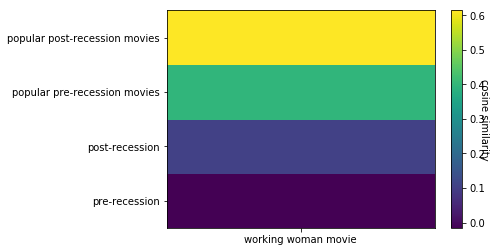

In [448]:
plot_heatmap(popular_two_periods, ['working woman movie'], keywordD2V)

Both plot summaries and keywords show that there are more movies depicting working woman in post-Great-Recession period than in pre-Great-Recession period, and people like working woman movies during post-Great-Recession period more than pre-Great-Recession period.

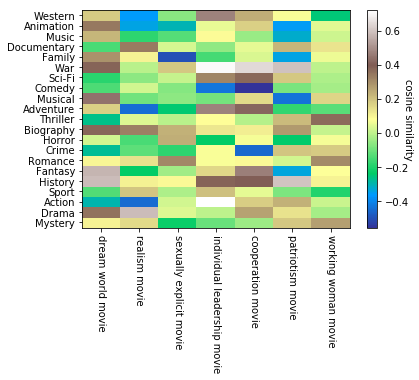

In [377]:
plot_heatmap(genres, features, plotD2V)

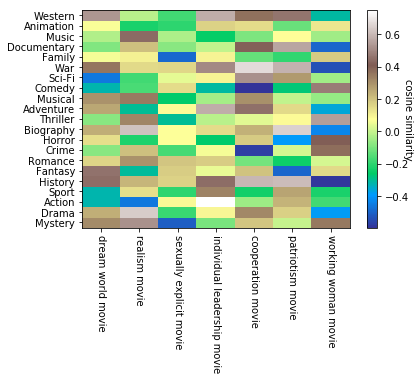

In [378]:
plot_heatmap(genres, features, keywordD2V)

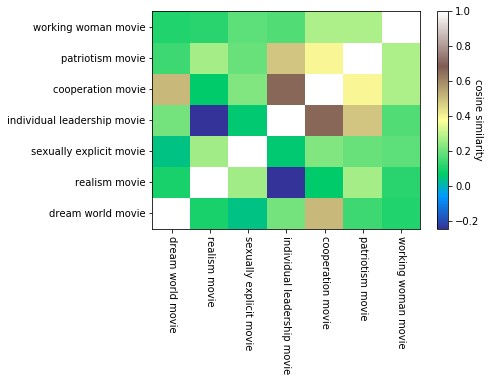

In [354]:
plot_heatmap(features, features, plotD2V)

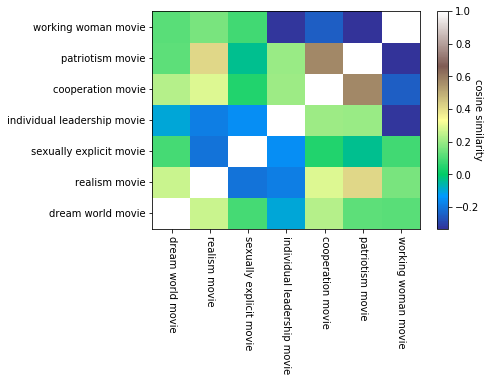

In [355]:
plot_heatmap(features, features, keywordD2V)

## Word Cloud
### Pre-Great-Recession movie plot summaries

(-0.5, 999.5, 999.5, -0.5)

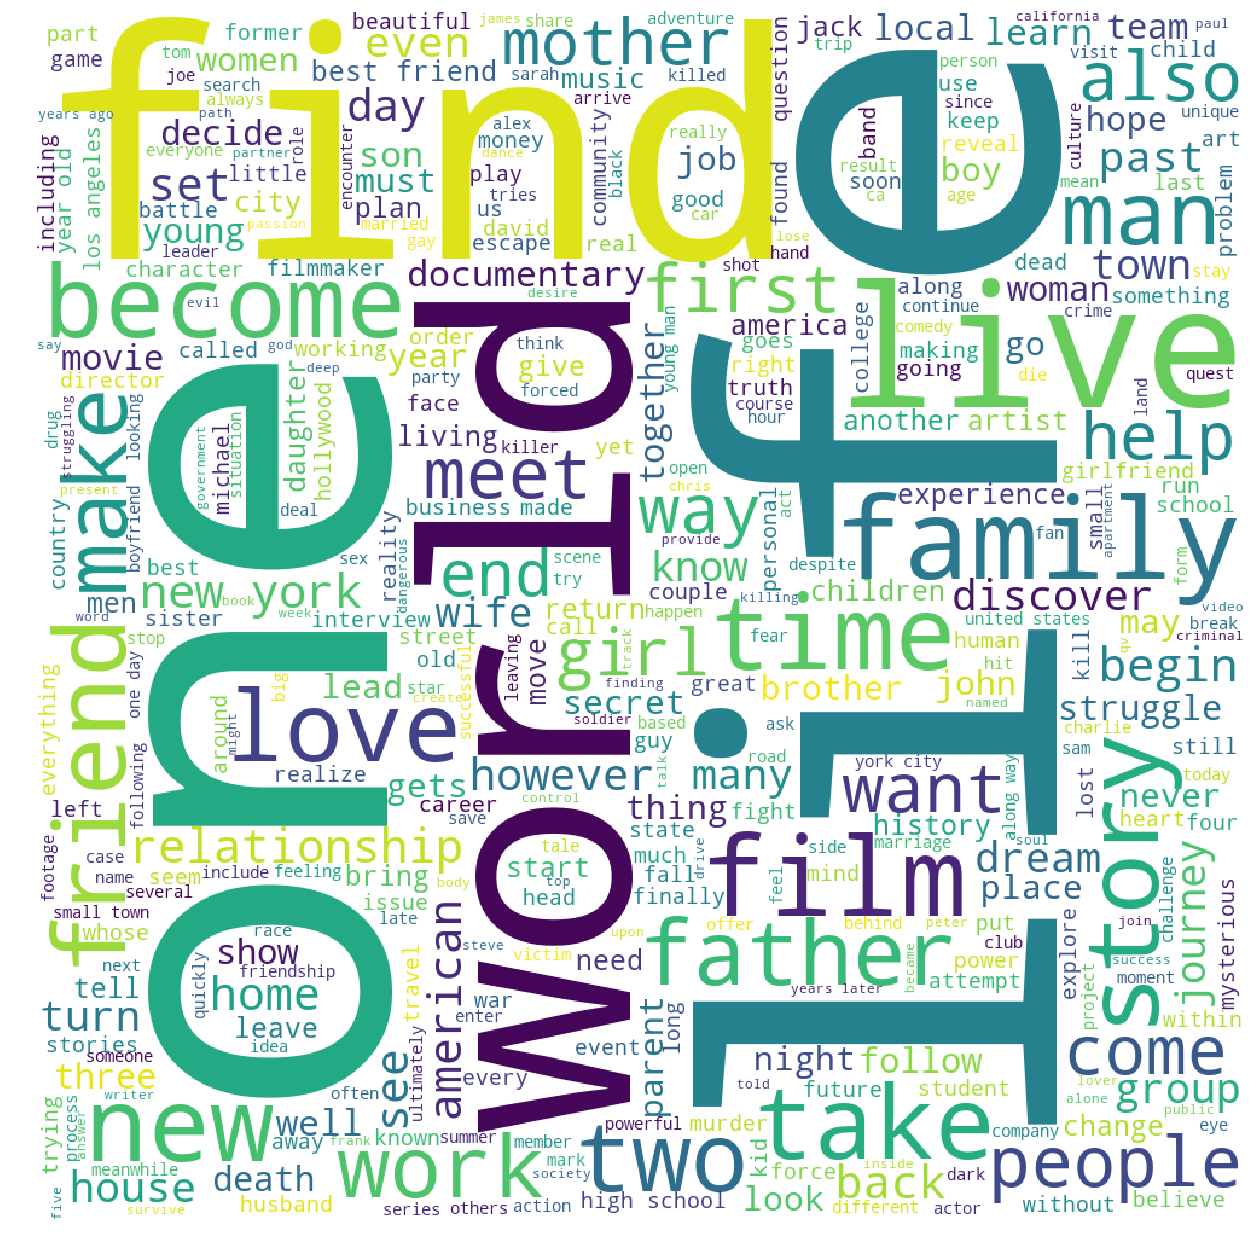

In [400]:
wc = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(plots[plots['period']=='pre-recession']['normalized_words'].sum()))
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')  
plt.imshow(wc)
plt.axis("off")
#plt.savefig("wa_word_cloud.pdf", format='pdf')

### Pre-Great-Recession movie keywords

(-0.5, 999.5, 999.5, -0.5)

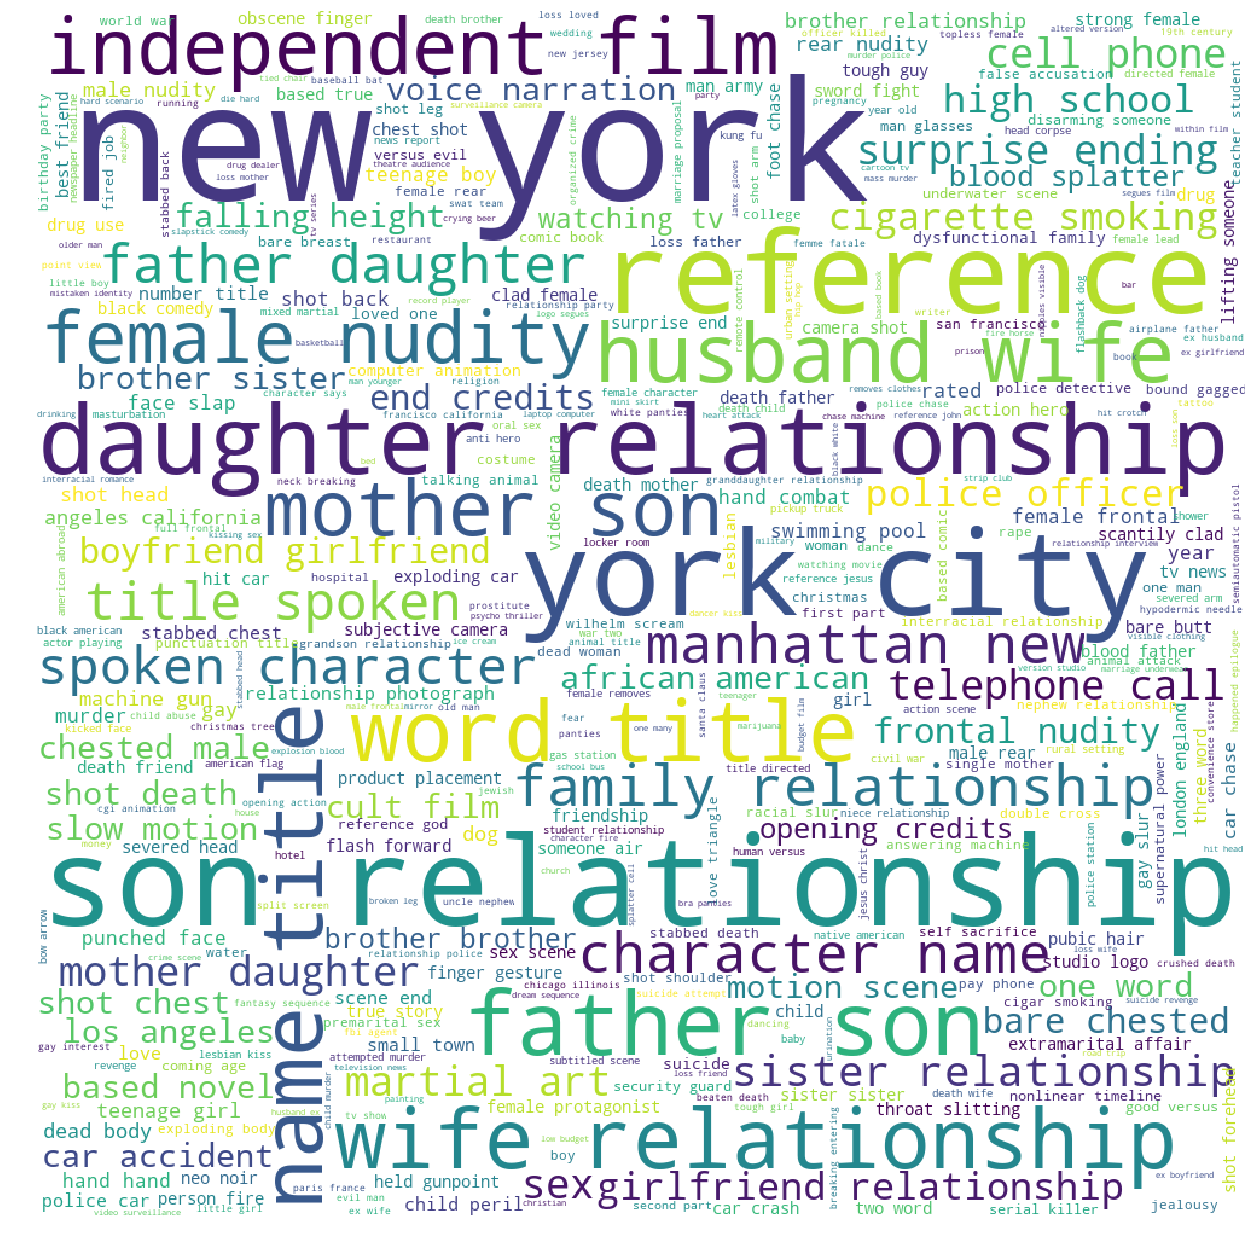

In [401]:
wc1 = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(plots[plots['period']=='pre-recession']['normalized_keywords'].sum()))
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')  
plt.imshow(wc1)
plt.axis("off")
#plt.savefig("wa_word_cloud.pdf", format='pdf')

### Popular Pre-Great-Recession movie plot summaries

(-0.5, 999.5, 999.5, -0.5)

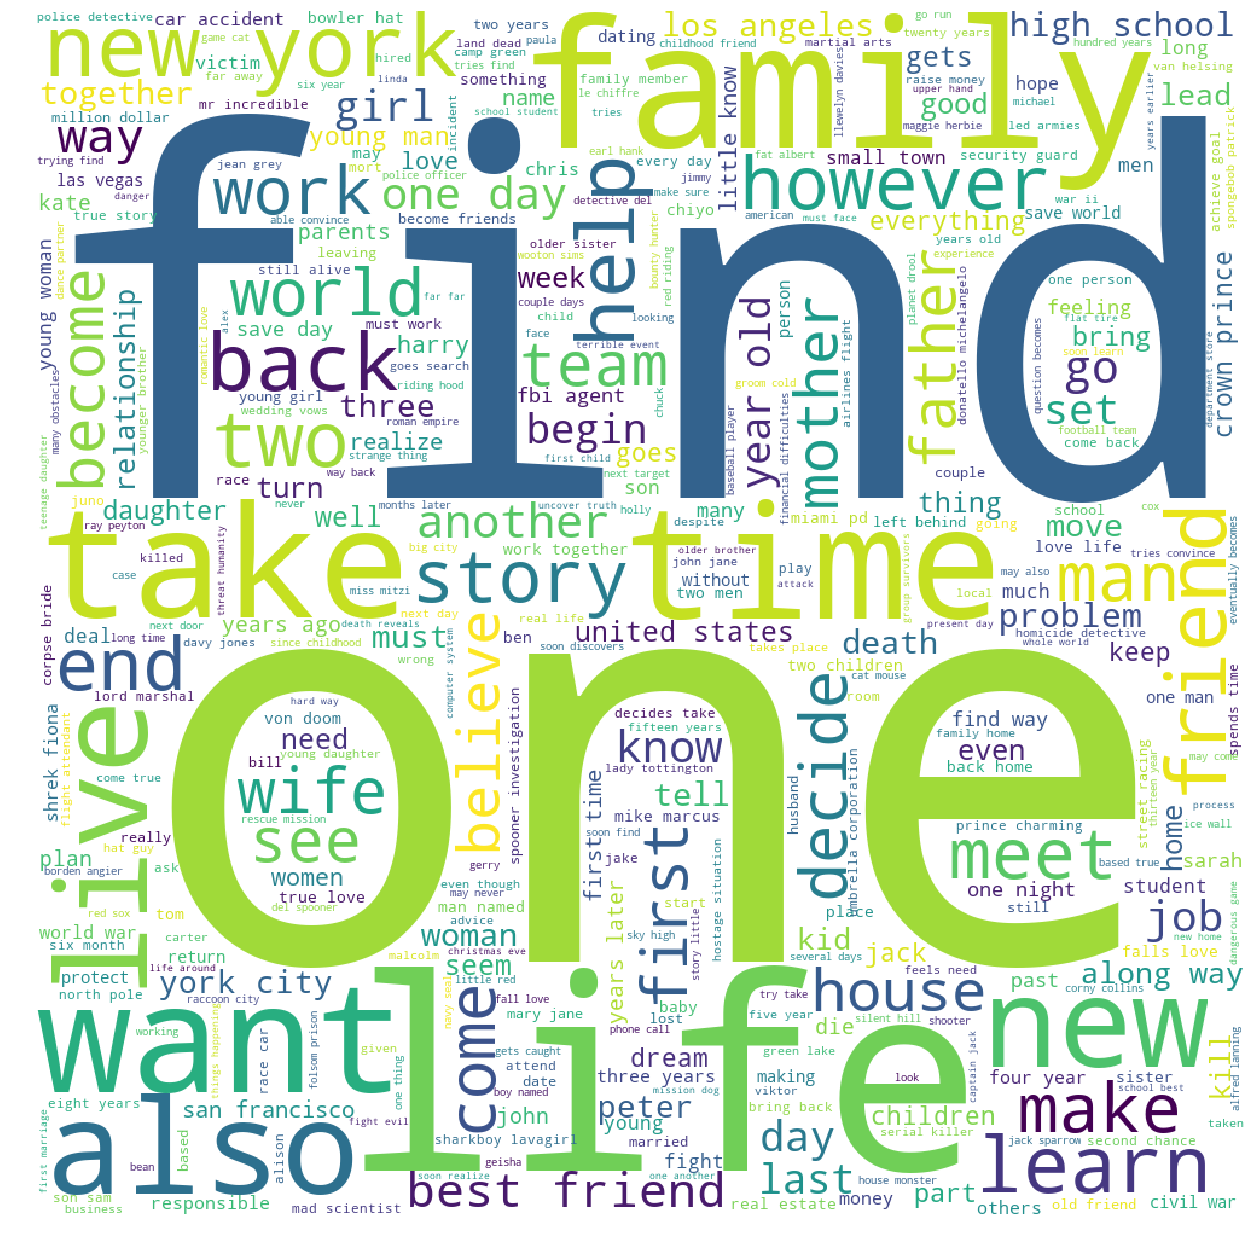

In [402]:
wc2 = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(plots[plots['popularity']=='popular pre-recession movies']['normalized_words'].sum()))
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')  
plt.imshow(wc2)
plt.axis("off")
#plt.savefig("wa_word_cloud.pdf", format='pdf')

### Popular Pre-Great-Recession movie keywords

(-0.5, 999.5, 999.5, -0.5)

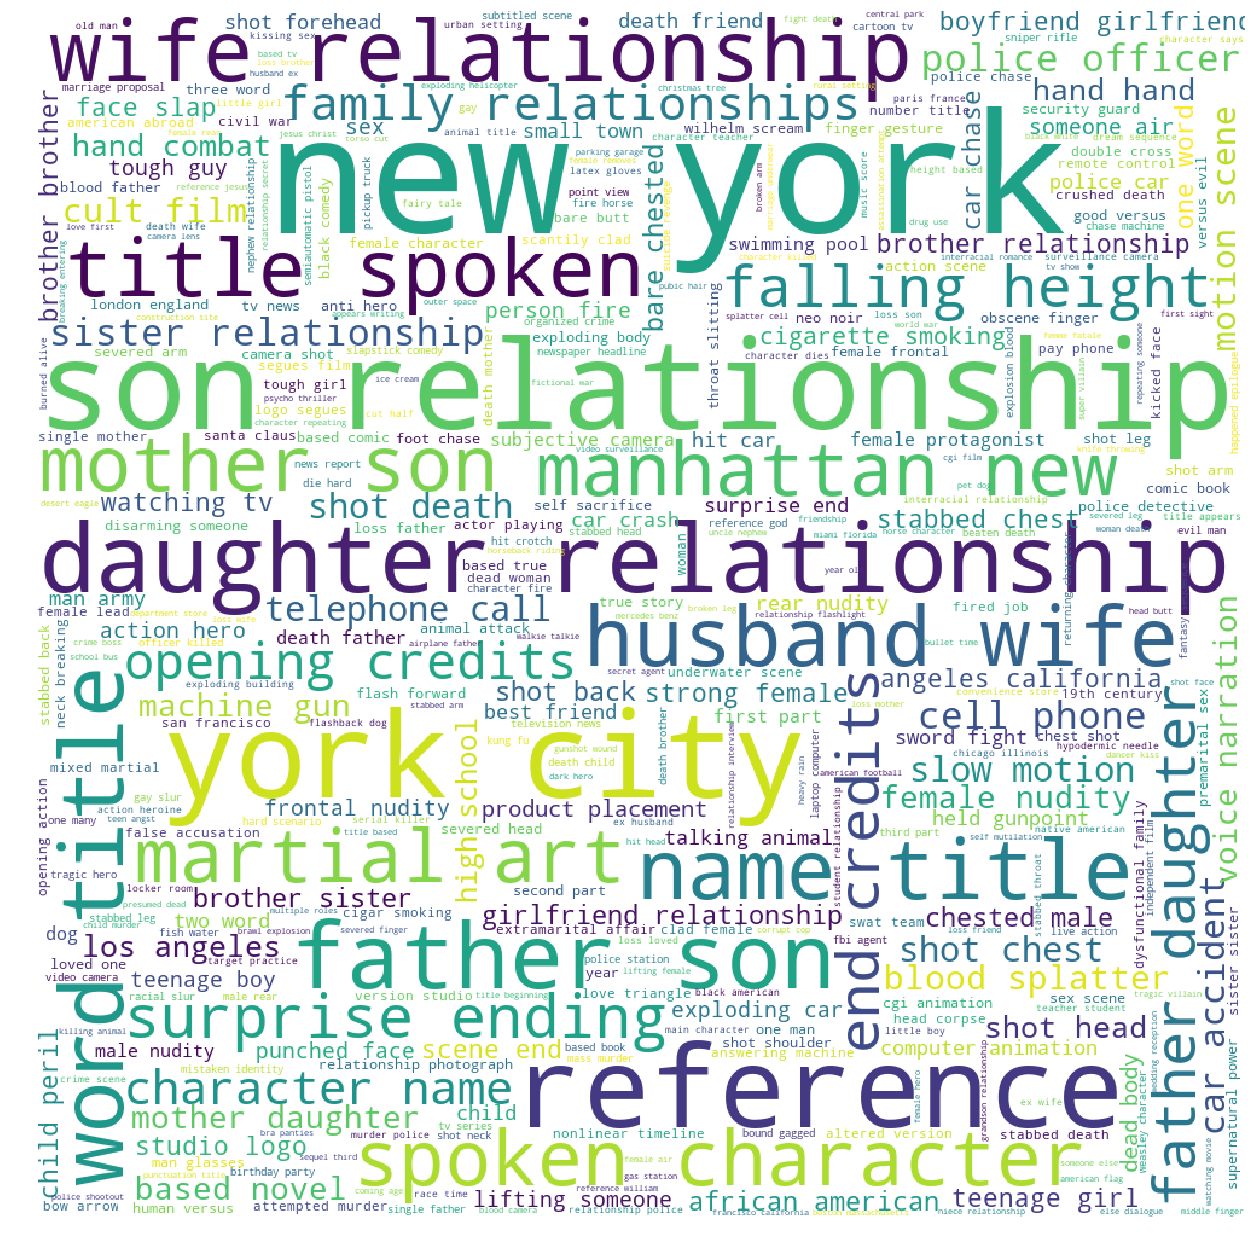

In [403]:
wc3 = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(plots[plots['popularity']=='popular pre-recession movies']['normalized_keywords'].sum()))
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')  
plt.imshow(wc3)
plt.axis("off")
#plt.savefig("wa_word_cloud.pdf", format='pdf')

### Post-Great-Recession movie plot summaries

(-0.5, 999.5, 999.5, -0.5)

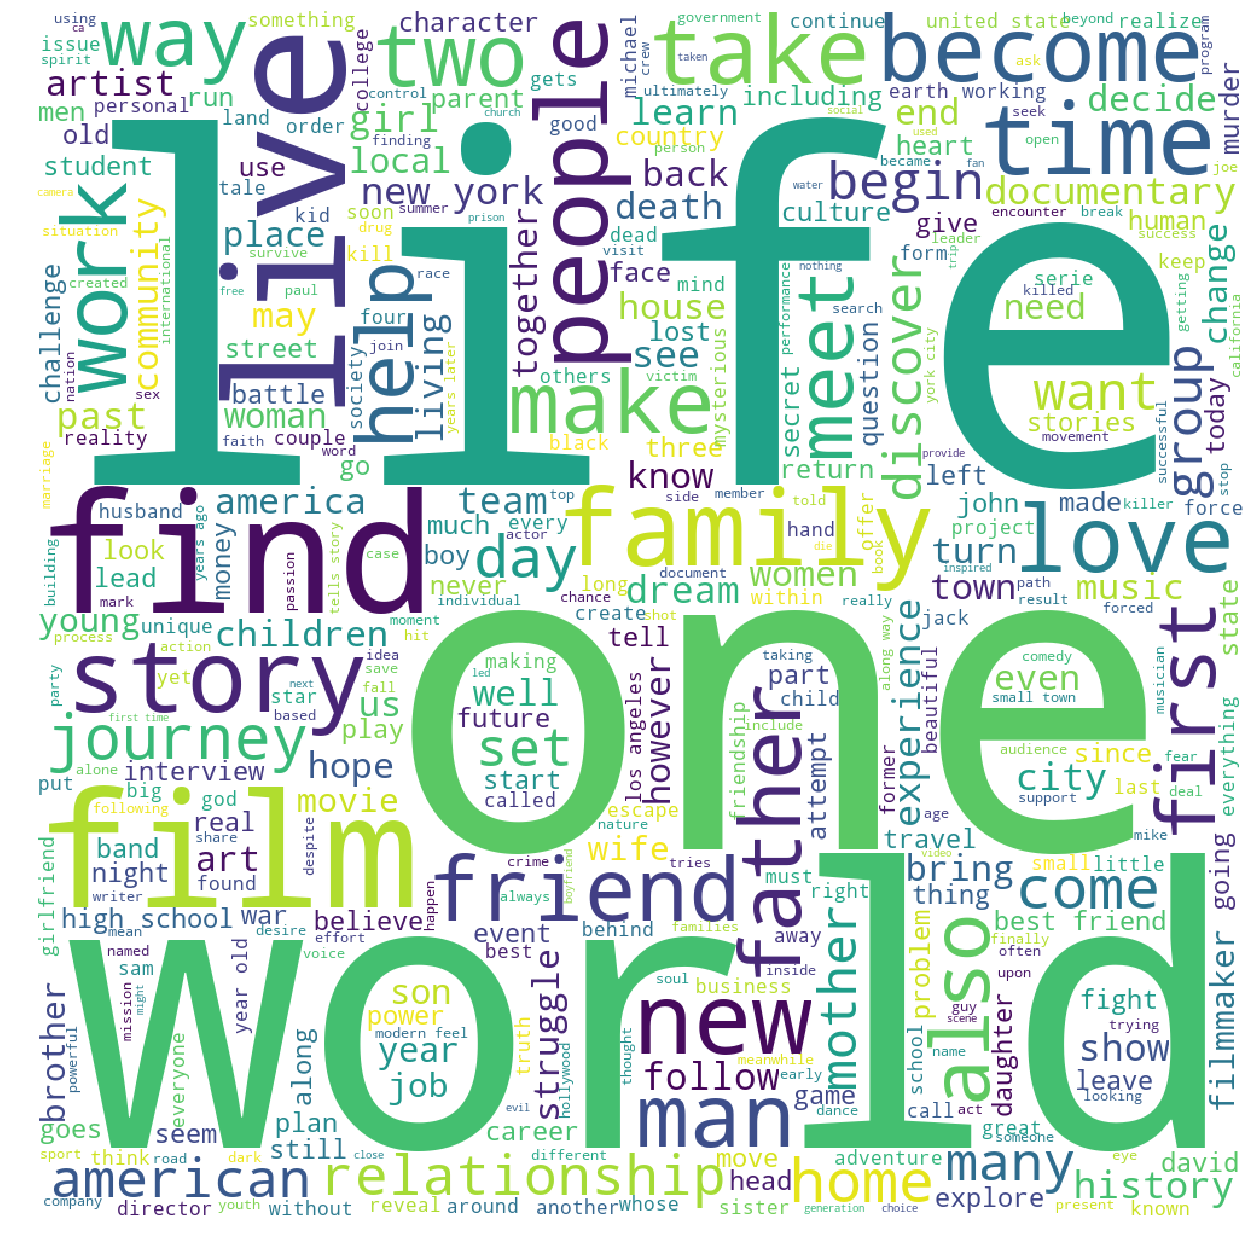

In [404]:
wc4 = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(plots[plots['period']=='post-recession']['normalized_words'].sum()))
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')  
plt.imshow(wc4)
plt.axis("off")
#plt.savefig("wa_word_cloud.pdf", format='pdf')

### Post-Great-Recession movie keywords

(-0.5, 999.5, 999.5, -0.5)

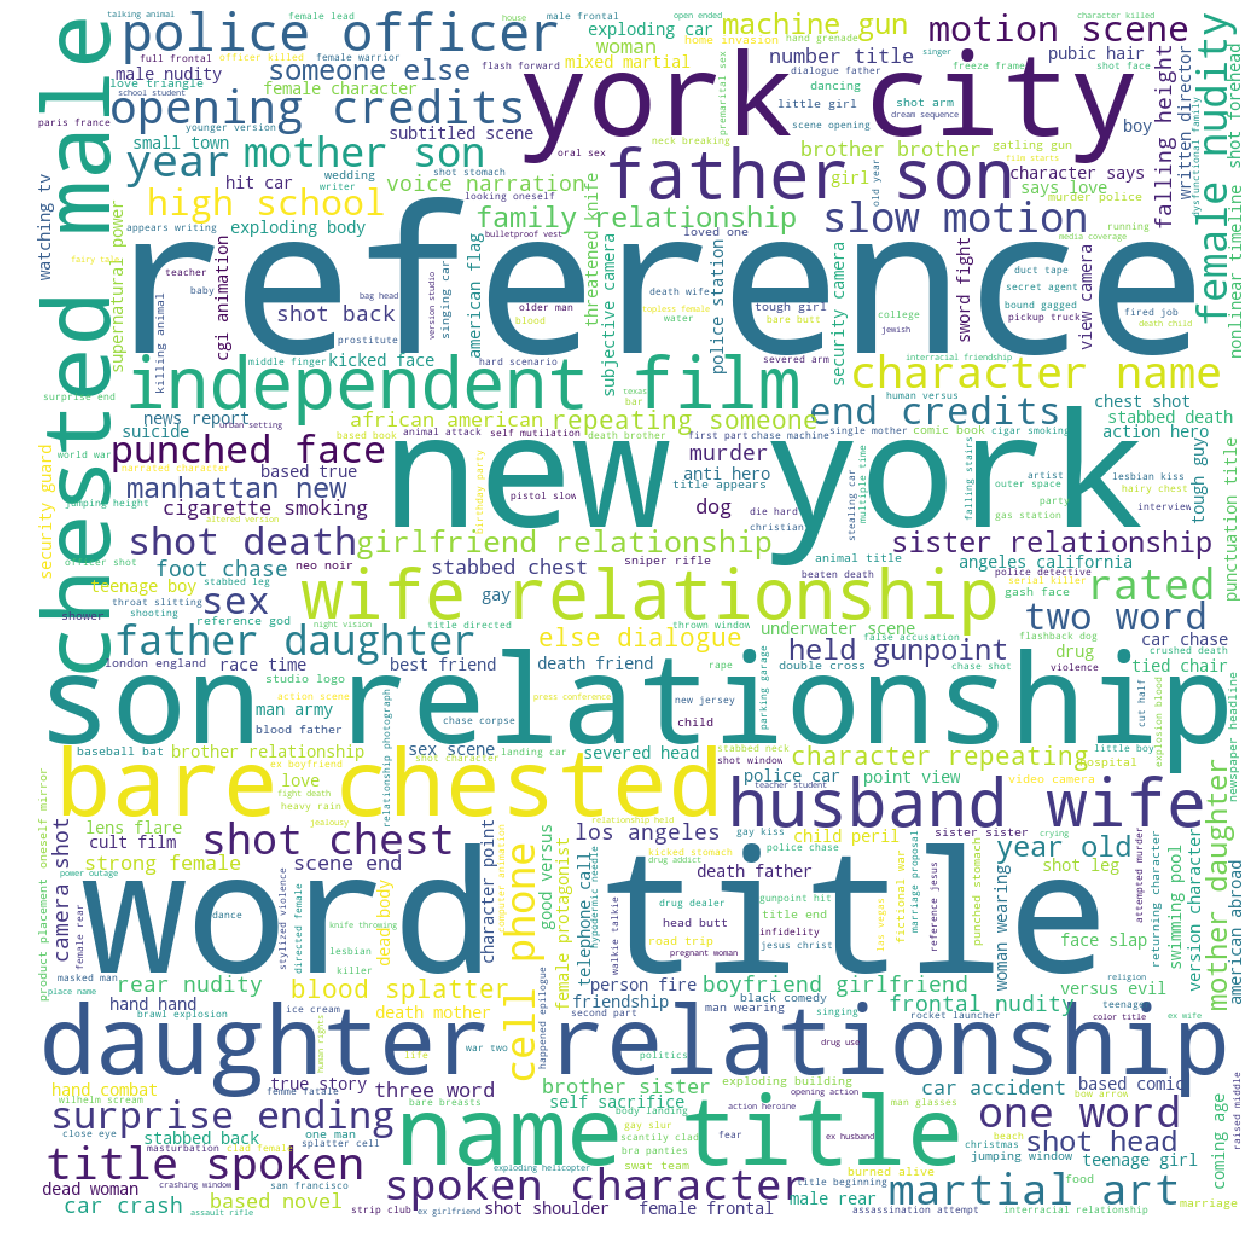

In [405]:
wc5 = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(plots[plots['period']=='post-recession']['normalized_keywords'].sum()))
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')  
plt.imshow(wc5)
plt.axis("off")
#plt.savefig("wa_word_cloud.pdf", format='pdf')

### Popular Post-Great-Recession movie plot summaries

(-0.5, 999.5, 999.5, -0.5)

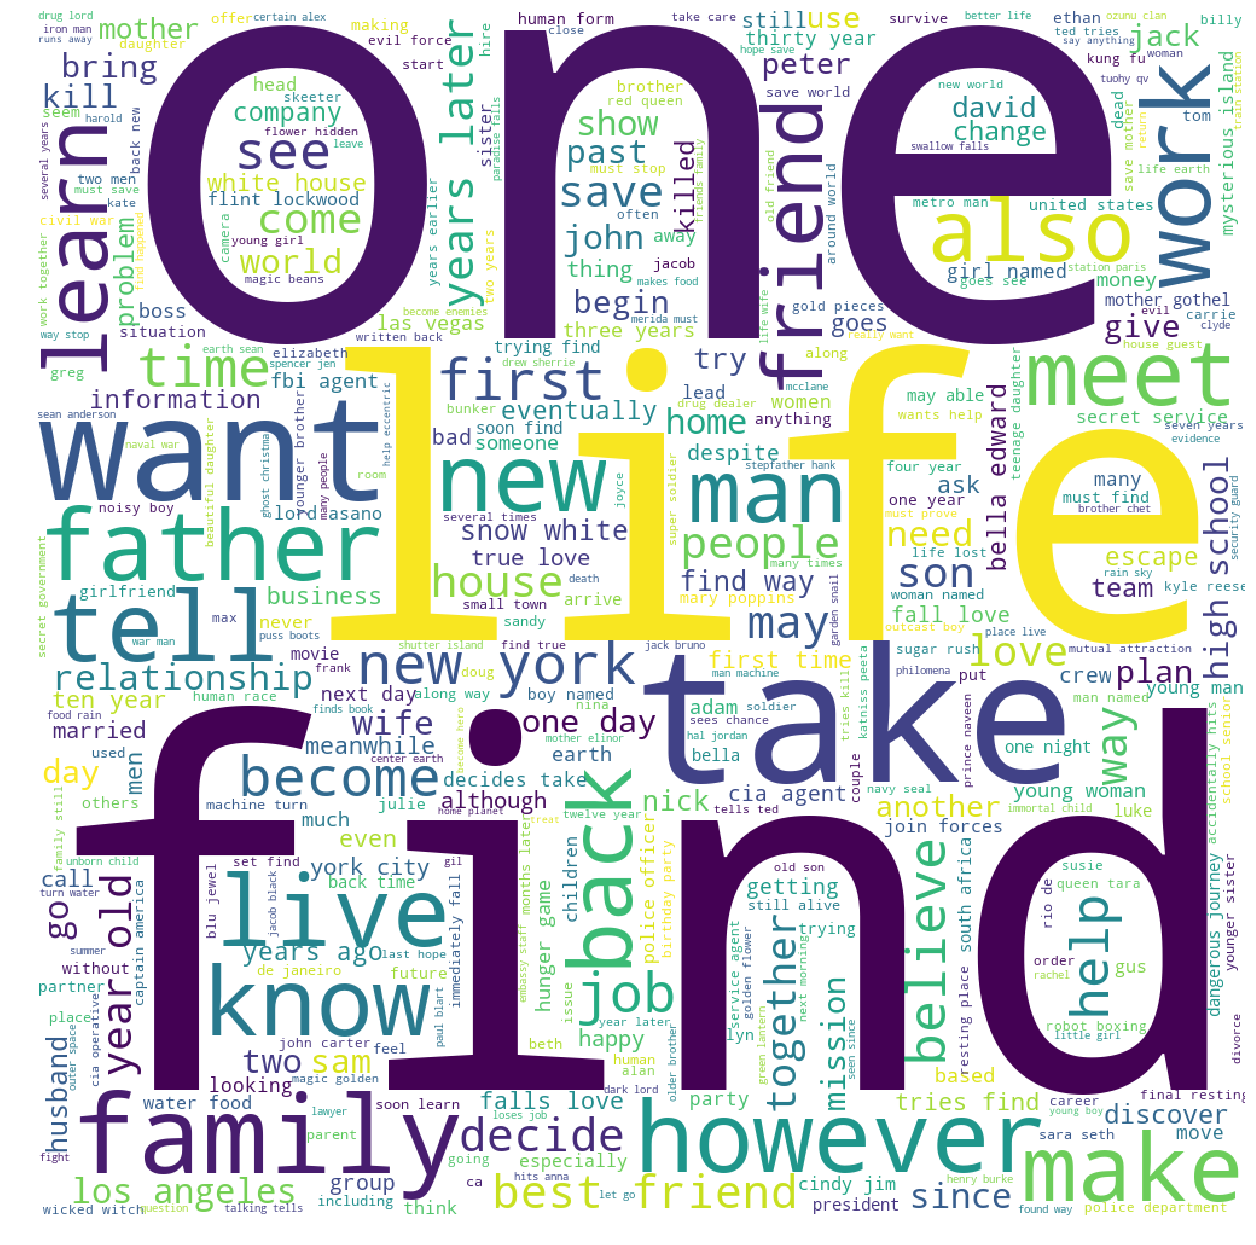

In [406]:
wc6 = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(plots[plots['popularity']=='popular post-recession movies']['normalized_words'].sum()))
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')  
plt.imshow(wc6)
plt.axis("off")
#plt.savefig("wa_word_cloud.pdf", format='pdf')

### Popular Post-Great-Recession movie keywords

(-0.5, 999.5, 999.5, -0.5)

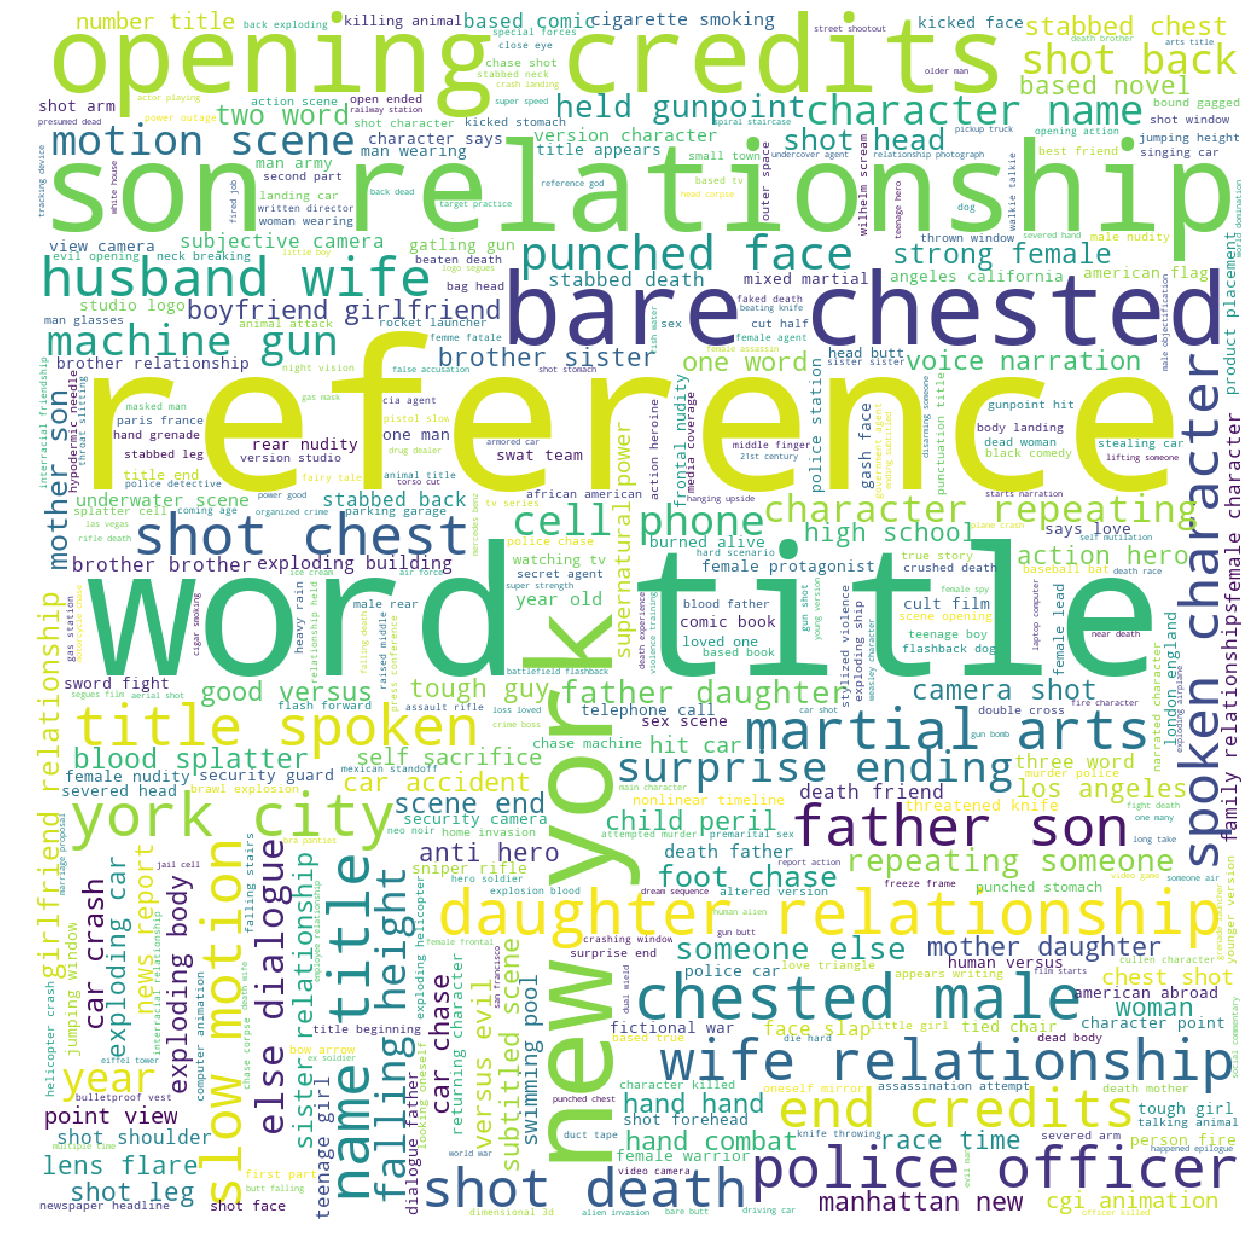

In [407]:
wc7 = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(plots[plots['popularity']=='popular post-recession movies']['normalized_keywords'].sum()))
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')  
plt.imshow(wc7)
plt.axis("off")
#plt.savefig("wa_word_cloud.pdf", format='pdf')